# Success Formula Analysis

## 1. Objective
The purpose of this analysis is to derive a Success Formula, a data driven explanation of what differentiates high performing employees from others, using a combination of statistical analysis, feature importance modeling, and visualization.
The goal is not only to find correlations but also to justify and visualize the factors that contribute to success within the organization.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report


## Data Understanding
Multiple datasets were provided in the Study Case DA.xlsx file, including:
1.   Employees: personal and demographic information
2.   Profiles_Psych: psychological and personality data
3.   PAPI_Scores: behavioral tendency indicators
4.   Strengths: top themes for each individual
5.   Performance_Yearly: annual performance ratings
6.   Competencies_Yearly: competency scores per pillar and year

Additional dimension tables (dim_...) were used to decode categorical IDs into meaningful names.

In [3]:
# load excel
xls = pd.ExcelFile('Study Case DA.xlsx')

In [4]:
print('Sheets:', xls.sheet_names)

Sheets: ['Talent Variable (TV) & Talent G', 'dim_companies', 'dim_areas', 'dim_positions', 'dim_departments', 'dim_divisions', 'dim_directorates', 'dim_grades', 'dim_education', 'dim_majors', 'dim_competency_pillars', 'employees', 'profiles_psych', 'papi_scores', 'strengths', 'performance_yearly', 'competencies_yearly']


In [5]:
# load sheet
employee = pd.read_excel(xls, sheet_name="employees")
profile_psych = pd.read_excel(xls, sheet_name="profiles_psych")
papi = pd.read_excel(xls, sheet_name="papi_scores")
strength = pd.read_excel(xls, sheet_name="strengths")
performance = pd.read_excel(xls, sheet_name="performance_yearly")
competency = pd.read_excel(xls, sheet_name="competencies_yearly")

In [6]:
employee_encode = employee.copy()

## 3. Data Preparation
All sheets were standardized by:
1.   Renaming columns to lowercase
2.   Merging categorical IDs with their respective dimension tables
3.   Cleaning duplicate suffixes (e.g., _x, _y)
4.   Keeping only descriptive columns (e.g., *_name)

The final master dataset combines employee, competency, psychometric, and performance data into a single analytical view.

In [7]:
# decode categorical column in employee
# lookup all sheet 'dim'
code_sheets = [s for s in xls.sheet_names if s.lower().startswith("dim_")]
code_lookup = {s: pd.read_excel(xls, sheet_name=s) for s in code_sheets}

# standardize all columns name
def normalize_cols(df):
    df.columns = [c.strip().lower() for c in df.columns]
    return df

employee = normalize_cols(employee)
for name, df in code_lookup.items():
    code_lookup[name] = normalize_cols(df)

# detect column in employee
custom_dim_map = {
    "company_id": "dim_companies",
    "education_id": "dim_education",
    "major_id": "dim_majors",
}

for col in employee.columns:
    if col.endswith("_id"):
        if col in custom_dim_map:
            dim_name = custom_dim_map[col]
        else:
            dim_name = f"dim_{col[:-3]}s"
            if dim_name not in code_lookup and f"dim_{col[:-3]}" in code_lookup:
                dim_name = f"dim_{col[:-3]}"

        if dim_name in code_lookup:
            dim_df = code_lookup[dim_name]
            key_col = col

            # search column name
            name_cols = [c for c in dim_df.columns if c != key_col and ('name' in c or not c.endswith('_id'))]
            if not name_cols:
                print(f"No name column found in {dim_name}, skipped.")
                continue

            name_col = name_cols[0]

            # rename column name to unique
            if name_col == 'name':
                new_col = col.replace('_id', '_name')
                dim_df = dim_df.rename(columns={name_col: new_col})
                name_col = new_col
            elif not name_col.endswith('_name'):
                # change column name with suffix _name
                new_col = name_col + "_name"
                dim_df = dim_df.rename(columns={name_col: new_col})
                name_col = new_col

            print(f"Merging {col} -> {dim_name} ({name_col})")
            employee = employee.merge(
                dim_df[[key_col, name_col]],
                on=key_col,
                how='left'
            )
        else:
            print(f"No lookup found for {col}")

# drop encoded column
for col in employee.columns:
    if col.endswith("_id"):
        name_col = col.replace("_id", "_name")
        if name_col in employee.columns:
            employee.drop(columns=[col], inplace=True)

if 'name' in employee.columns:
    employee.drop(columns=['name'], inplace=True)

ordered = ['employee_id', 'fullname', 'nip'] + \
          [c for c in employee.columns if c not in ['employee_id','fullname','nip']]
employee = employee[ordered]

# drop x y
def resolve_suffix_cols(df):
    new_df = df.copy()
    to_drop = []
    rename_map = {}
    for col in new_df.columns:
        if col.endswith("_x"):
            base = col[:-2]
            y_col = base + "_y"
            if y_col in new_df.columns:
                to_drop.append(col)
                rename_map[y_col] = base
    new_df = new_df.drop(columns=to_drop)
    new_df = new_df.rename(columns=rename_map)
    for c in ['name', 'name_x', 'name_y']:
        if c in new_df.columns:
            new_df.drop(columns=[c], inplace=True)
    return new_df

employee = resolve_suffix_cols(employee)
# print the merged sheet
print("Cleaned columns:", employee.columns.tolist())
employee.head()


No lookup found for employee_id
Merging company_id -> dim_companies (company_name)
Merging area_id -> dim_areas (area_name)
Merging position_id -> dim_positions (position_name)
Merging department_id -> dim_departments (department_name)
Merging division_id -> dim_divisions (division_name)
Merging directorate_id -> dim_directorates (directorate_name)
Merging grade_id -> dim_grades (grade_name)
Merging education_id -> dim_education (education_name)
Merging major_id -> dim_majors (major_name)
Cleaned columns: ['employee_id', 'fullname', 'nip', 'years_of_service_months', 'company_name', 'area_name', 'position_name', 'department_name', 'division_name', 'directorate_name', 'grade_name', 'education_name', 'major_name']


,employee_id,fullname,nip,years_of_service_months,company_name,area_name,position_name,department_name,division_name,directorate_name,grade_name,education_name,major_name
0,EMP100000,Rendra Pratama,806137,64,PT Aurora Beauty Indonesia,Store,Brand Executive,R&D,Product Dev,Technology,IV,S2,Business
1,EMP100001,Wulan Setiawan,476388,16,PT Mandala Distribution Center,Store,HRBP,Operations,Talent Management,Technology,III,D3,Design
2,EMP100002,Julia Jatmiko Situmorang,941921,58,PT Aurora Beauty Indonesia,Plant,Sales Supervisor,Finance,Digital Marketing,Technology,III,S2,Business
3,EMP100003,Oka Halim,751615,15,PT Aurora Beauty Indonesia,Plant,HRBP,HR,Digital Marketing,Commercial,IV,S1,Psychology
4,EMP100004,Dwi Pratama,443809,34,PT Lumo Cosmetics Asia,Store,Supply Planner,Operations,Product Dev,Technology,III,D3,Psychology


In [8]:
# pivot competencies
competency = competency[competency['year'] == 2025]

competency_wide = competency.pivot_table(
    index='employee_id',
    columns='pillar_code',
    values='score',
    fill_value=0
).reset_index()

competency_wide.columns = [str(c) for c in competency_wide.columns]
competency_wide.head()


,employee_id,CEX,CSI,FTC,GDR,IDS,LIE,QDD,SEA,STO,VCU
0,DUP1942,4.0,5.0,5.0,5.0,5.0,0.0,5.0,5.0,5.0,5.0
1,DUP2096,3.0,3.0,2.0,3.0,4.0,3.0,2.0,3.0,3.0,3.0
2,DUP2722,3.0,5.0,5.0,5.0,4.0,5.0,3.0,4.0,0.0,5.0
3,DUP3015,2.0,3.0,3.0,3.0,4.0,3.0,3.0,3.0,4.0,3.0
4,DUP3452,3.0,2.0,2.0,3.0,3.0,3.0,4.0,4.0,3.0,4.0


In [9]:
# pivot papi score
papi_wide = papi.pivot_table(
    index='employee_id',
    columns='scale_code',
    values='score',
    aggfunc='mean'
).reset_index()

papi_wide.columns = [str(c) for c in papi_wide.columns]
papi_wide.head()

,employee_id,Papi_A,Papi_B,Papi_C,Papi_D,Papi_E,Papi_F,Papi_G,Papi_I,Papi_K,Papi_L,Papi_N,Papi_O,Papi_P,Papi_R,Papi_S,Papi_T,Papi_V,Papi_W,Papi_X,Papi_Z
0,DUP1942,6.0,NaN,1.0,4.0,3.0,5.0,4.0,1.0,3.0,6.0,NaN,3.0,5.0,7.0,9.0,9.0,1.0,8.0,3.0,NaN
1,DUP2096,1.0,6.0,9.0,3.0,4.0,1.0,2.0,6.0,9.0,3.0,1.0,4.0,4.0,6.0,8.0,2.0,6.0,3.0,8.0,2.0
2,DUP2722,2.0,NaN,6.0,4.0,1.0,4.0,9.0,9.0,1.0,3.0,8.0,2.0,NaN,6.0,1.0,7.0,3.0,6.0,3.0,3.0
3,DUP3015,5.0,4.0,3.0,4.0,9.0,2.0,8.0,9.0,1.0,7.0,5.0,1.0,8.0,7.0,3.0,NaN,NaN,3.0,5.0,3.0
4,DUP3452,7.0,9.0,1.0,9.0,7.0,3.0,NaN,2.0,1.0,4.0,NaN,NaN,4.0,2.0,9.0,NaN,9.0,1.0,6.0,4.0


In [10]:
# pivot strength
N = 5
strength = strength[strength['rank'] <= N]

strength_pivot = strength.pivot_table(
    index='employee_id',
    columns='rank',
    values='theme',
    aggfunc='first'
).reset_index()

strength_pivot.columns = ['employee_id'] + [f'theme_{i}' for i in range(1, N+1)]
strength_pivot.head()

,employee_id,theme_1,theme_2,theme_3,theme_4,theme_5
0,DUP1942,Learner,Maximizer,Ideation,Harmony,Restorative
1,DUP2096,Command,Significance,Competition,Discipline,Woo
2,DUP2722,Individualization,Self-Assurance,NaN,Analytical,Input
3,DUP3015,Responsibility,Context,Includer,Communication,Ideation
4,DUP3452,Developer,Arranger,Self-Assurance,Futuristic,Learner


In [11]:
# filter performance 2025
perf_2025 = (
    performance[performance['year'] == 2025]
    .drop(columns=['year'])
    .drop_duplicates(subset=['employee_id'])
)

In [12]:
# new df with all assessment aspect (master)
master = (
    employee
    .merge(perf_2025, on='employee_id', how='left')
    .merge(competency_wide, on='employee_id', how='left')
    .merge(papi_wide, on='employee_id', how='left')
    .merge(profile_psych, on='employee_id', how='left')
    .merge(strength_pivot, on='employee_id', how='left')
)
master.head()

,employee_id,fullname,nip,years_of_service_months,company_name,area_name,position_name,department_name,division_name,directorate_name,grade_name,education_name,major_name,rating,CEX,CSI,FTC,GDR,IDS,LIE,QDD,SEA,STO,VCU,Papi_A,Papi_B,Papi_C,Papi_D,Papi_E,Papi_F,Papi_G,Papi_I,Papi_K,Papi_L,Papi_N,Papi_O,Papi_P,Papi_R,Papi_S,Papi_T,Papi_V,Papi_W,Papi_X,Papi_Z,pauli,faxtor,disc,disc_word,mbti,iq,gtq,tiki,theme_1,theme_2,theme_3,theme_4,theme_5
0,EMP100000,Rendra Pratama,806137,64,PT Aurora Beauty Indonesia,Store,Brand Executive,R&D,Product Dev,Technology,IV,S2,Business,3.0,3.0,3.0,4.0,3.0,4.0,3.0,3.0,2.0,3.0,4.0,1.0,6.0,5.0,NaN,1.0,3.0,5.0,8.0,NaN,7.0,2.0,9.0,3.0,7.0,9.0,3.0,4.0,4.0,2.0,1.0,86,75,SI,Steadiness-Influencer,NaN,94.0,33.0,2,NaN,Adaptability,Context,Competition,Activator
1,EMP100001,Wulan Setiawan,476388,16,PT Mandala Distribution Center,Store,HRBP,Operations,Talent Management,Technology,III,D3,Design,3.0,2.0,3.0,3.0,2.0,3.0,2.0,2.0,0.0,2.0,3.0,3.0,1.0,7.0,4.0,2.0,2.0,2.0,4.0,6.0,7.0,8.0,9.0,5.0,3.0,3.0,6.0,7.0,1.0,6.0,9.0,48,52,DS,Dominant-Steadiness,INTP,94.0,17.0,3,Responsibility,Includer,Significance,Context,Adaptability
2,EMP100002,Julia Jatmiko Situmorang,941921,58,PT Aurora Beauty Indonesia,Plant,Sales Supervisor,Finance,Digital Marketing,Technology,III,S2,Business,4.0,5.0,3.0,0.0,3.0,3.0,3.0,5.0,3.0,4.0,4.0,2.0,NaN,4.0,2.0,5.0,7.0,2.0,8.0,4.0,NaN,9.0,5.0,3.0,1.0,3.0,9.0,9.0,1.0,4.0,6.0,66,38,DC,Dominant-Conscientious,NaN,109.0,20.0,3,Restorative,Maximizer,Woo,Includer,Command
3,EMP100003,Oka Halim,751615,15,PT Aurora Beauty Indonesia,Plant,HRBP,HR,Digital Marketing,Commercial,IV,S1,Psychology,3.0,3.0,3.0,3.0,4.0,3.0,2.0,3.0,3.0,0.0,4.0,NaN,8.0,9.0,2.0,6.0,5.0,3.0,8.0,5.0,3.0,9.0,1.0,8.0,9.0,1.0,1.0,7.0,7.0,4.0,3.0,39,63,SI,Steadiness-Influencer,ENTJ,85.0,39.0,3,Belief,Intellection,Arranger,NaN,Adaptability
4,EMP100004,Dwi Pratama,443809,34,PT Lumo Cosmetics Asia,Store,Supply Planner,Operations,Product Dev,Technology,III,D3,Psychology,4.0,4.0,3.0,3.0,4.0,3.0,0.0,3.0,3.0,5.0,0.0,5.0,4.0,4.0,5.0,3.0,7.0,8.0,9.0,1.0,3.0,7.0,6.0,7.0,1.0,2.0,9.0,2.0,1.0,3.0,6.0,75,100,NaN,Steadiness-Conscientious,INTJ,134.0,21.0,9,Deliberative,Command,Woo,Communication,Ideation


In [13]:
# check missing value
master.info()
master.isna().mean().sort_values(ascending=False).head(15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2010 entries, 0 to 2009
Data columns (total 57 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   employee_id              2010 non-null   object 
 1   fullname                 2010 non-null   object 
 2   nip                      2010 non-null   int64  
 3   years_of_service_months  2010 non-null   int64  
 4   company_name             2010 non-null   object 
 5   area_name                2010 non-null   object 
 6   position_name            2010 non-null   object 
 7   department_name          2010 non-null   object 
 8   division_name            2010 non-null   object 
 9   directorate_name         2010 non-null   object 
 10  grade_name               2010 non-null   object 
 11  education_name           2010 non-null   object 
 12  major_name               2010 non-null   object 
 13  rating                   1794 non-null   float64
 14  CEX                     

,0
iq,0.226866
gtq,0.165174
rating,0.107463
Papi_O,0.094030
Papi_K,0.089552
theme_2,0.088060
Papi_L,0.088060
theme_4,0.088060
Papi_F,0.086070
disc,0.085075


In [14]:
# performance rating 5
master['is_high'] = (master['rating'] == 5).astype(int)
print(master['is_high'].value_counts())

is_high
0    1842
1     168
Name: count, dtype: int64


In [15]:
# check rating distribution
master['rating'].value_counts(normalize=True)

,proportion
rating,
3.0,0.354515
4.0,0.270903
2.0,0.192308
5.0,0.093645
1.0,0.086399
6.0,0.001115
0.0,0.001115


In [16]:
# only data with rating 1-5
master = master[master['rating'].between(1, 5)]

In [17]:
# check again rating distribution
master['rating'].value_counts(normalize=True).sort_index()

,proportion
rating,
1.0,0.086592
2.0,0.192737
3.0,0.355307
4.0,0.271508
5.0,0.093855


In [18]:
# Clean MBTI to 16 types
master['mbti'] = (
    master['mbti']
    .astype(str)
    .str.upper()
    .str.replace(r'[^A-Z]', '', regex=True)
    .str.strip()
)

valid_mbti = ['ISTJ','ISFJ','INFJ','INTJ',
              'ISTP','ISFP','INFP','INTP',
              'ESTP','ESFP','ENFP','ENTP',
              'ESTJ','ESFJ','ENFJ','ENTJ']

master.loc[~master['mbti'].isin(valid_mbti), 'mbti'] = np.nan

master['mbti'].value_counts(dropna=False)


,count
mbti,
ENFP,138
NaN,134
ENFJ,117
INTP,114
INFP,108
ENTP,105
ISTP,104
ESFJ,104
ENTJ,103


In [19]:
# Invert scale of Papi Z and K
master['Papi_Z'] = 10 - master['Papi_Z']
master['Papi_K'] = 10 - master['Papi_K']

In [20]:
# Grouping Papi

papi_cols = [
    'Papi_A','Papi_B','Papi_C','Papi_D','Papi_E','Papi_F','Papi_G',
    'Papi_I','Papi_K','Papi_L','Papi_N','Papi_O','Papi_P','Papi_R',
    'Papi_S','Papi_T','Papi_V','Papi_W','Papi_X','Papi_Z'
]

papi_df = master[papi_cols].copy()

papi_df = papi_df.fillna(papi_df.mean())

papi_df['Papi_Z'] = 10 - papi_df['Papi_Z']
papi_df['Papi_K'] = 10 - papi_df['Papi_K']

scaler = MinMaxScaler()
papi_norm = pd.DataFrame(scaler.fit_transform(papi_df), columns=papi_cols)

master['PAPI_Leadership'] = papi_norm[['Papi_L','Papi_P','Papi_I']].mean(axis=1)
master['PAPI_Activity'] = papi_norm[['Papi_T','Papi_V']].mean(axis=1)
master['PAPI_Social'] = papi_norm[['Papi_O','Papi_B','Papi_S','Papi_X']].mean(axis=1)
master['PAPI_Style'] = papi_norm[['Papi_C','Papi_D','Papi_R']].mean(axis=1)
master['PAPI_Temperament'] = papi_norm[['Papi_Z','Papi_E','Papi_K']].mean(axis=1)
master['PAPI_Followership'] = papi_norm[['Papi_F','Papi_W']].mean(axis=1)
master['PAPI_Direction'] = papi_norm[['Papi_G','Papi_N','Papi_A']].mean(axis=1)


## 4. Exploratory Data Analysis

/tmp/ipython-input-2807657767.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=master, x='is_high', y='years_of_service_months', palette='viridis')


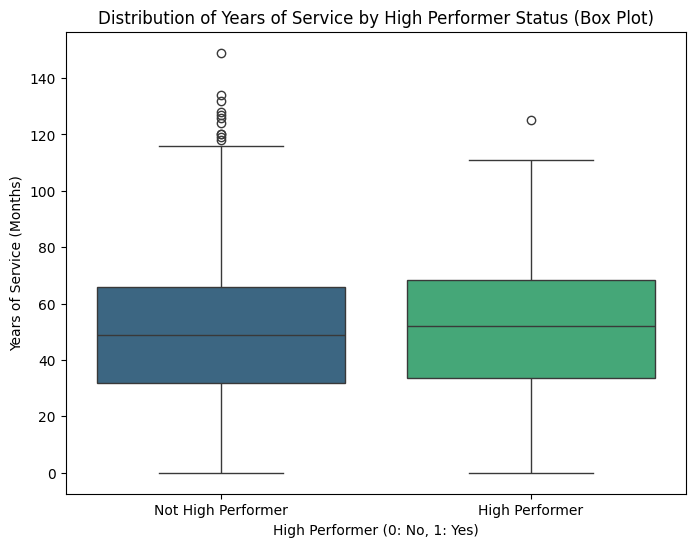

In [21]:
# Years of Service Distribution

plt.figure(figsize=(8, 6))
sns.boxplot(data=master, x='is_high', y='years_of_service_months', palette='viridis')
plt.title('Distribution of Years of Service by High Performer Status (Box Plot)')
plt.xlabel('High Performer (0: No, 1: Yes)')
plt.ylabel('Years of Service (Months)')
plt.xticks([0, 1], ['Not High Performer', 'High Performer'])
plt.show()

There is no significant difference in years of service between high and non-high performers.
This suggests that tenure alone does not determine success within the organization.

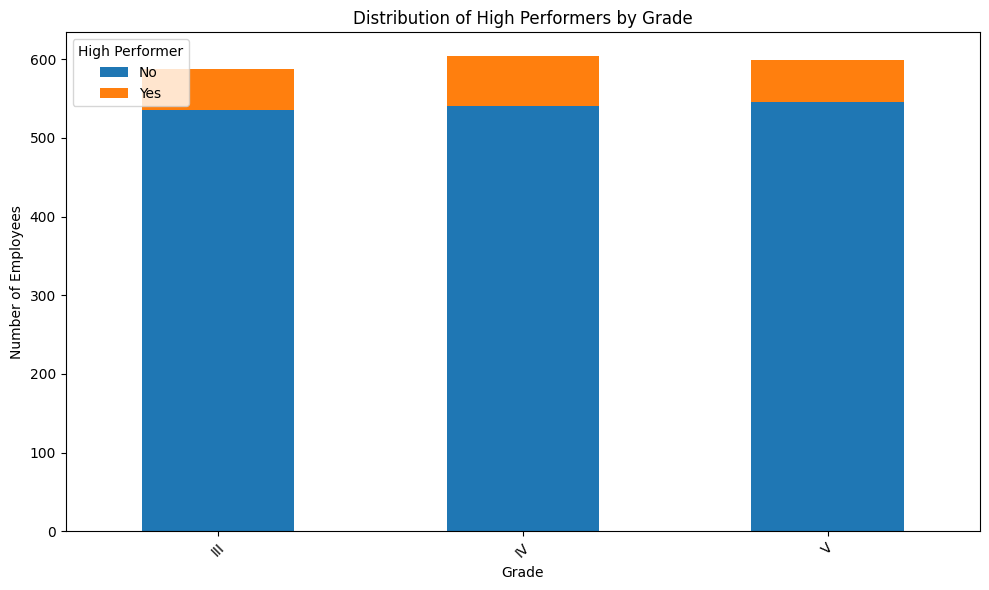

In [22]:
# Grade Dist
grade_distribution = master.groupby(['grade_name', 'is_high']).size().unstack(fill_value=0)

grade_distribution.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Distribution of High Performers by Grade')
plt.xlabel('Grade')
plt.ylabel('Number of Employees')
plt.xticks(rotation=45)
plt.legend(title='High Performer', labels=['No', 'Yes'])
plt.tight_layout()
plt.show()

The distribution of high performers is relatively similar across grades.
No single grade level shows a clear dominance of high performers.

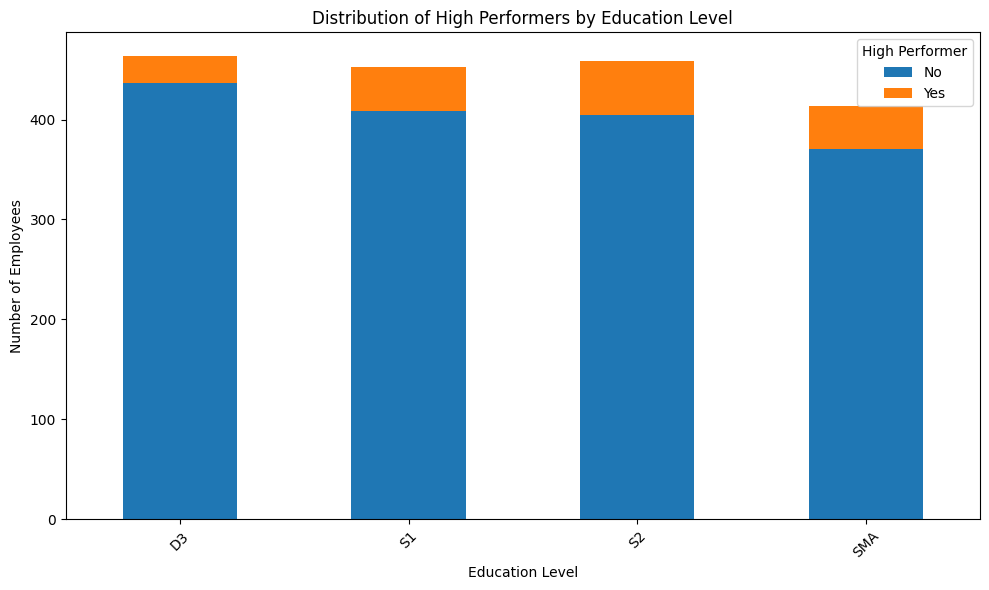

In [23]:
# Edu Dist
education_distribution = master.groupby(['education_name', 'is_high']).size().unstack(fill_value=0)

education_distribution.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Distribution of High Performers by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Number of Employees')
plt.xticks(rotation=45)
plt.legend(title='High Performer', labels=['No', 'Yes'])
plt.tight_layout()
plt.show()

Education level also does not show strong differentiation between high and non-high performers.

Top positive correlations:
 SEA    0.245837
CEX    0.151866
STO    0.126192
VCU    0.123750
IDS    0.118118
LIE    0.114517
CSI    0.104093
QDD    0.095467
GDR    0.083567
FTC    0.078322
Name: is_high, dtype: float64

Top negative correlations:
 Papi_D            -0.012500
Papi_X            -0.012674
Papi_C            -0.017684
Papi_A            -0.022966
faxtor            -0.033090
Papi_T            -0.034049
Papi_G            -0.036185
Papi_S            -0.037151
PAPI_Direction    -0.045721
PAPI_Leadership   -0.050783
Name: is_high, dtype: float64


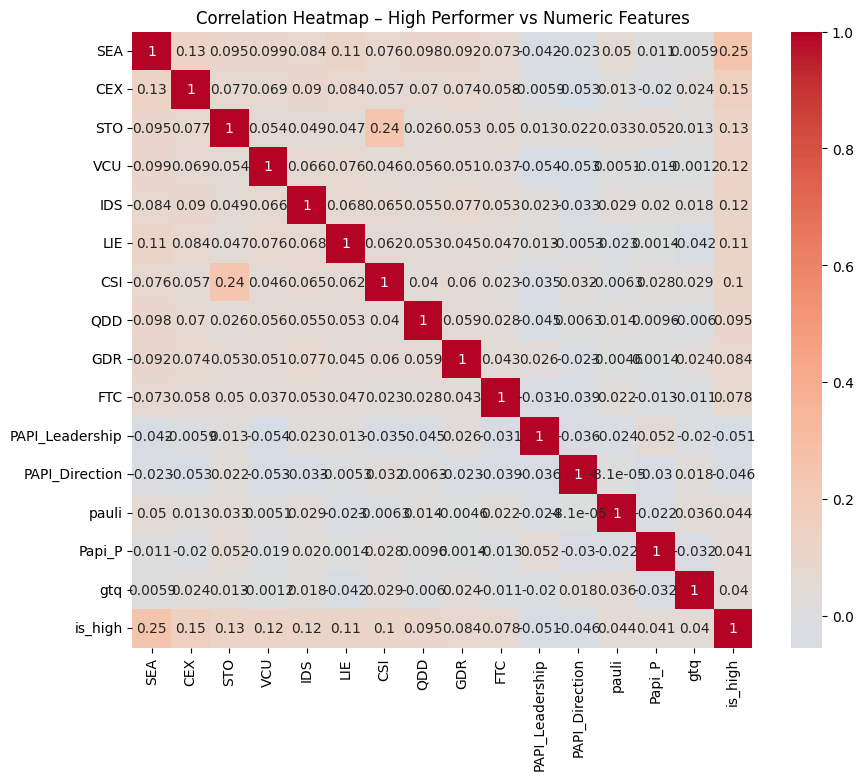

In [24]:
# Heatmap
num_cols = [c for c in master.select_dtypes(include=['number']).columns if c not in ['rating']]

corr = master[num_cols].corr()['is_high'].drop('is_high').sort_values(ascending=False)

print("Top positive correlations:\n", corr.head(10))
print("\nTop negative correlations:\n", corr.tail(10))

top_feats = corr.abs().sort_values(ascending=False).head(15).index
corr_subset = master[top_feats.tolist() + ['is_high']].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_subset, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap – High Performer vs Numeric Features')
plt.show()


A heatmap was used to identify numeric features most correlated with is_high.
Although overall correlations were weak (mostly < 0.2), SEA stood out with the highest positive correlation (~0.20) among numeric predictors and was therefore shortlisted for potential inclusion in the Success Formula.

In [25]:
pd.set_option('display.max_columns', None)

In [26]:
master.head()

,employee_id,fullname,nip,years_of_service_months,company_name,area_name,position_name,department_name,division_name,directorate_name,grade_name,education_name,major_name,rating,CEX,CSI,FTC,GDR,IDS,LIE,QDD,SEA,STO,VCU,Papi_A,Papi_B,Papi_C,Papi_D,Papi_E,Papi_F,Papi_G,Papi_I,Papi_K,Papi_L,Papi_N,Papi_O,Papi_P,Papi_R,Papi_S,Papi_T,Papi_V,Papi_W,Papi_X,Papi_Z,pauli,faxtor,disc,disc_word,mbti,iq,gtq,tiki,theme_1,theme_2,theme_3,theme_4,theme_5,is_high,PAPI_Leadership,PAPI_Activity,PAPI_Social,PAPI_Style,PAPI_Temperament,PAPI_Followership,PAPI_Direction
0,EMP100000,Rendra Pratama,806137,64,PT Aurora Beauty Indonesia,Store,Brand Executive,R&D,Product Dev,Technology,IV,S2,Business,3.0,3.0,3.0,4.0,3.0,4.0,3.0,3.0,2.0,3.0,4.0,1.0,6.0,5.0,NaN,1.0,3.0,5.0,8.0,NaN,7.0,2.0,9.0,3.0,7.0,9.0,3.0,4.0,4.0,2.0,9.0,86,75,SI,Steadiness-Influencer,NaN,94.0,33.0,2,NaN,Adaptability,Context,Competition,Activator,0,0.625000,0.3125,0.687500,0.580750,0.168640,0.3125,0.208333
1,EMP100001,Wulan Setiawan,476388,16,PT Mandala Distribution Center,Store,HRBP,Operations,Talent Management,Technology,III,D3,Design,3.0,2.0,3.0,3.0,2.0,3.0,2.0,2.0,0.0,2.0,3.0,3.0,1.0,7.0,4.0,2.0,2.0,2.0,4.0,4.0,7.0,8.0,9.0,5.0,3.0,3.0,6.0,7.0,1.0,6.0,1.0,48,52,DS,Dominant-Steadiness,INTP,94.0,17.0,3,Responsibility,Includer,Significance,Context,Adaptability,0,0.541667,0.6875,0.468750,0.458333,0.583333,0.0625,0.416667
2,EMP100002,Julia Jatmiko Situmorang,941921,58,PT Aurora Beauty Indonesia,Plant,Sales Supervisor,Finance,Digital Marketing,Technology,III,S2,Business,4.0,5.0,3.0,0.0,3.0,3.0,3.0,5.0,3.0,4.0,4.0,2.0,NaN,4.0,2.0,5.0,7.0,2.0,8.0,6.0,NaN,9.0,5.0,3.0,1.0,3.0,9.0,9.0,1.0,4.0,4.0,66,38,DC,Dominant-Conscientious,NaN,109.0,20.0,3,Restorative,Maximizer,Woo,Includer,Command,0,0.546015,1.0000,0.403497,0.166667,0.500000,0.3750,0.416667
3,EMP100003,Oka Halim,751615,15,PT Aurora Beauty Indonesia,Plant,HRBP,HR,Digital Marketing,Commercial,IV,S1,Psychology,3.0,3.0,3.0,3.0,4.0,3.0,2.0,3.0,3.0,0.0,4.0,NaN,8.0,9.0,2.0,6.0,5.0,3.0,8.0,5.0,3.0,9.0,1.0,8.0,9.0,1.0,1.0,7.0,7.0,4.0,7.0,39,63,SI,Steadiness-Influencer,ENTJ,85.0,39.0,3,Belief,Intellection,Arranger,NaN,Adaptability,0,0.666667,0.3750,0.312500,0.708333,0.458333,0.6250,0.583434
4,EMP100004,Dwi Pratama,443809,34,PT Lumo Cosmetics Asia,Store,Supply Planner,Operations,Product Dev,Technology,III,D3,Psychology,4.0,4.0,3.0,3.0,4.0,3.0,0.0,3.0,3.0,5.0,0.0,5.0,4.0,4.0,5.0,3.0,7.0,8.0,9.0,9.0,3.0,7.0,6.0,7.0,1.0,2.0,9.0,2.0,1.0,3.0,4.0,75,100,NaN,Steadiness-Conscientious,INTJ,134.0,21.0,9,Deliberative,Command,Woo,Communication,Ideation,0,0.666667,0.5625,0.343750,0.291667,0.291667,0.3750,0.708333


In [27]:
pca = PCA(n_components=3)
pillar_cols = ['GDR','CEX','IDS','QDD','STO','SEA','VCU','LIE','FTC','CSI']
pillar_pca = pca.fit_transform(master[pillar_cols])
pd.DataFrame(pca.components_, columns=pillar_cols)

# PC1 = CSI (choose for represent PC1), STO
# PC 2 = QDD (choose for represent PC2), VCU
# PC3 = FTC

,GDR,CEX,IDS,QDD,STO,SEA,VCU,LIE,FTC,CSI
0,0.153944,0.075695,0.108761,0.186283,0.512237,0.095488,0.229050,0.103998,0.162837,0.750161
1,0.171540,0.070693,0.106766,0.544348,-0.137223,0.091837,0.534600,0.106475,0.432336,-0.382819
2,-0.009266,0.002739,0.006071,-0.511451,0.117871,-0.002627,-0.173904,-0.002577,0.829397,-0.078982


The PCA layer was excluded from the final model because competency scores are already domain-specific constructs.

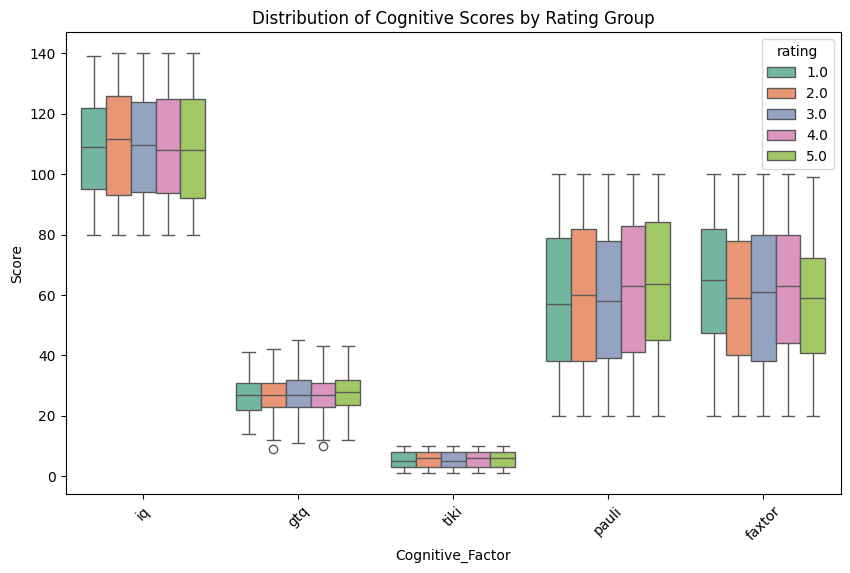

In [28]:
cognitive_cols = ['iq','gtq','tiki','pauli','faxtor']

# boxplot
plt.figure(figsize=(10,6))
df_melt = master.melt(id_vars='rating', value_vars=cognitive_cols, var_name='Cognitive_Factor', value_name='Score')
sns.boxplot(data=df_melt, x='Cognitive_Factor', y='Score', hue='rating', palette='Set2')
plt.title('Distribution of Cognitive Scores by Rating Group')
plt.xticks(rotation=45)
plt.show()

Notable variation appears in Pauli and Faxtor, indicating potential linkage to high performance.
GTQ also shows moderate differentiation, but not consistently across performance levels.

## 5. Feature Selection

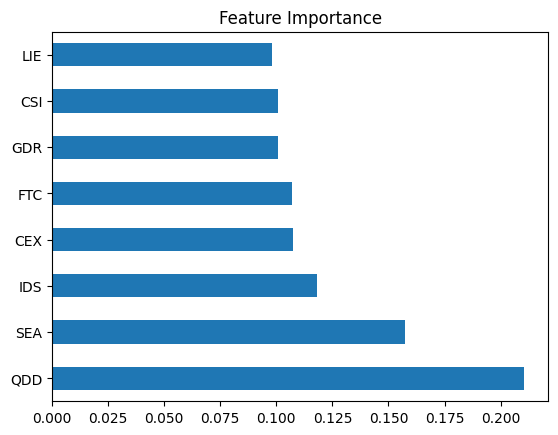

In [29]:
# feature Importance for Old Aspect
X = master[['SEA','CEX','CSI','IDS','LIE','QDD','GDR','FTC']]
y = master['is_high']
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X, y)
importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
importance.plot(kind='barh')
plt.title('Feature Importance')
plt.show()

A Random Forest Classifier was trained using major competency pillars (SEA, CEX, CSI, IDS, LIE, QDD, GDR, FTC).
Top 3 importance scores were QDD, SEA, and IDS, confirming their strong predictive contribution.
However, applying a cutoff threshold of 0.125 isolates QDD and SEA as the most robust indicators.

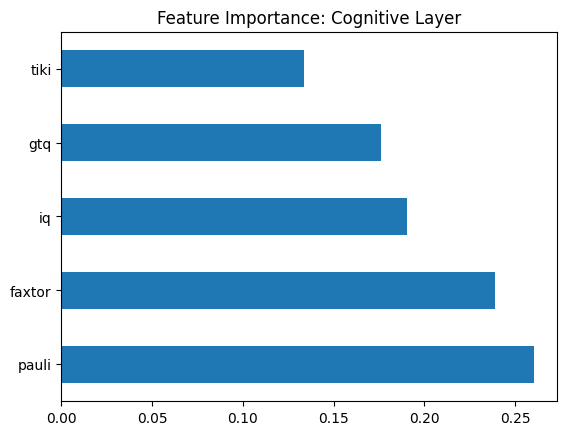

              precision    recall  f1-score   support

           0       0.89      0.99      0.94       481
           1       0.00      0.00      0.00        56

    accuracy                           0.89       537
   macro avg       0.45      0.50      0.47       537
weighted avg       0.80      0.89      0.84       537



In [30]:
# Feature Importance Cognitive
X_cog = master[cognitive_cols].fillna(master[cognitive_cols].median())
y = master['is_high']

scaler = StandardScaler()
X_cog_scaled = scaler.fit_transform(X_cog)

X_train, X_test, y_train, y_test = train_test_split(X_cog_scaled, y, test_size=0.3, random_state=42)

rf_cog = RandomForestClassifier(n_estimators=200, random_state=42)
rf_cog.fit(X_train, y_train)

importances = pd.Series(rf_cog.feature_importances_, index=cognitive_cols).sort_values(ascending=False)
importances.plot(kind='barh', title='Feature Importance: Cognitive Layer')
plt.show()

print(classification_report(y_test, rf_cog.predict(X_test)))


A scaled Random Forest model was trained on cognitive scores.
Importance ranking confirmed Pauli and Faxtor as the most influential features (importance > 0.2).

Pauli and Faxtor reflect core elements of concentration, accuracy, and mental persistence, which align well with known success traits.

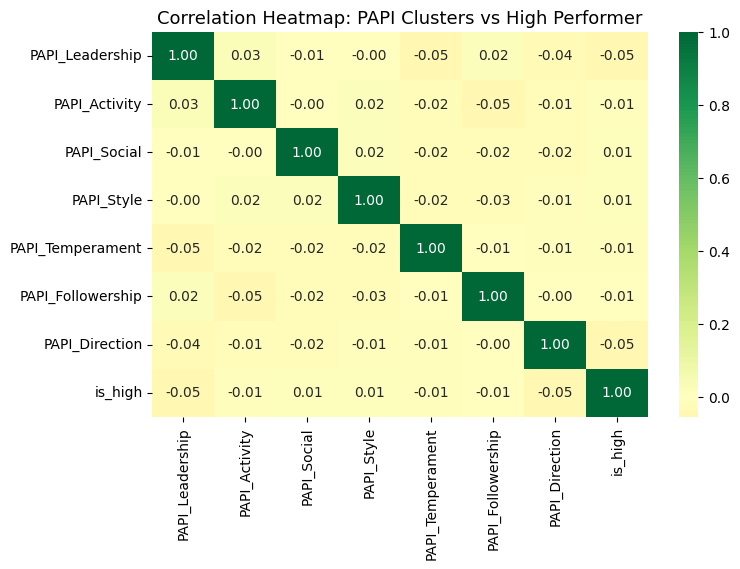

In [31]:
# Correlation of Papi Groups
papi_corr = master[['PAPI_Leadership','PAPI_Activity','PAPI_Social','PAPI_Style',
                    'PAPI_Temperament','PAPI_Followership','PAPI_Direction','is_high']].corr()

plt.figure(figsize=(8,5))
sns.heatmap(papi_corr, annot=True, cmap='RdYlGn', center=0, fmt=".2f")
plt.title('Correlation Heatmap: PAPI Clusters vs High Performer', fontsize=13)
plt.show()


Initial grouping into thematic clusters (e.g., Leadership, Social, Style, Temperament, etc.) revealed low correlations with is_high.
Thus, grouping was retained for interpretive purposes only, not for predictive modeling.

              precision    recall  f1-score   support

           0       0.91      1.00      0.95       487
           1       1.00      0.02      0.04        50

    accuracy                           0.91       537
   macro avg       0.95      0.51      0.50       537
weighted avg       0.92      0.91      0.87       537



/tmp/ipython-input-2914997274.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=importances.index, palette="viridis")


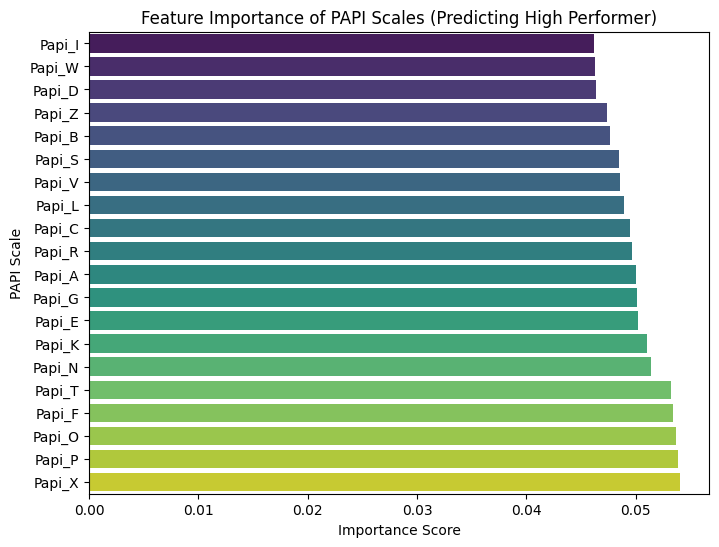

In [32]:
papi_cols = [
    'Papi_A','Papi_B','Papi_C','Papi_D','Papi_E','Papi_F','Papi_G',
    'Papi_I','Papi_K','Papi_L','Papi_N','Papi_O','Papi_P','Papi_R',
    'Papi_S','Papi_T','Papi_V','Papi_W','Papi_X','Papi_Z'
]

papi_df = master[papi_cols].copy()
papi_df = papi_df.fillna(papi_df.mean())
papi_df['Papi_Z'] = 10 - papi_df['Papi_Z']
papi_df['Papi_K'] = 10 - papi_df['Papi_K']

X = papi_df
y = master['is_high']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

importances = pd.Series(rf.feature_importances_, index=papi_cols).sort_values(ascending=True)

plt.figure(figsize=(8,6))
sns.barplot(x=importances, y=importances.index, palette="viridis")
plt.title('Feature Importance of PAPI Scales (Predicting High Performer)')
plt.xlabel('Importance Score')
plt.ylabel('PAPI Scale')
plt.show()


A Random Forest model across all PAPI scales identified Papi_O, Papi_X, Papi_P, Papi_F, and Papi_T as the most relevant features.
However, due to redundancy within PAPI clusters, Papi_X was selected to represent the Social domain (replacing Papi_O).

Top predictors were grouped conceptually:
*   Papi_X → Social orientation
*   Papi_P → Leadership drive
*   Papi_F → Followership or team compliance
*   Papi_T → Discipline and task focus

## Consolidated Success Formula
| Domain (TGV) | Variables | Rationale |
|---|---|---|
| Social | SEA, Papi X | Interpersonal awareness and collaboration |
| Discipline | QDD, Papi T | Structure, rule compliance, and task consistency |
| Decision | IDS | Analytical and judgment ability |
| Leadership | Papi P | Initiative, direction, and influence |
| Followership | Papi F | Dependability and cooperation |
| Cognitive | Pauli, Faxtor | Processing speed and logical accuracy |

These six Talent Group Variables (TGVs) capture both behavioral and cognitive dimensions of high performance.
Each aligns with measurable psychometric or competency features, making them suitable for operational modeling and talent prediction.

## Output Preparation
To integrate with the enterprise data platform, three CSV files were generated:
*   employees.csv: employee metadata and performance flag
*   employee_scores.csv: normalized scores of selected Talent Variables
*   tv_meta.csv: mapping of Talent Variables (TV) to their respective Talent Group Variables (TGV)

These datasets are ready for ingestion into PostgreSQL for further dashboarding and advanced analytics.

In [33]:
# Check integration of Master and Employee
missing_ids = set(master['employee_id']) - set(employee['employee_id'])
print("Jumlah ID master yang tidak ada di employees:", len(missing_ids))

Jumlah ID master yang tidak ada di employees: 0


In [34]:
# CSV employee metadata for Postgres
employees = employee.merge(master[['employee_id', 'is_high']], on='employee_id', how='left')
employees.to_csv("employees.csv", index=False)

In [35]:
# CSV score for Postgres
tv_cols = ['SEA', 'QDD', 'IDS', 'pauli', 'faxtor',
           'Papi_P', 'Papi_F', 'Papi_T', 'Papi_X']

employee_scores = master.melt(
    id_vars=['employee_id'],
    value_vars=tv_cols,
    var_name='tv_name',
    value_name='score'
)

employee_scores = employee_scores.dropna(subset=['score'])

employee_scores.to_csv("employee_scores.csv", index=False)

In [36]:
# CSV for TV TGV
tv_meta = pd.DataFrame([
    ['SEA','Social','higher',True],
    ['Papi_X','Social','higher',True],
    ['QDD','Discipline','higher',True],
    ['Papi_T','Discipline','higher',True],
    ['IDS','Decision','higher',True],
    ['Papi_P','Leadership','higher',True],
    ['Papi_F','Followership','higher',True],
    ['pauli','Cognitive','higher',True],
    ['faxtor','Cognitive','higher',True],
], columns=['tv_name','tgv_name','direction','is_numeric'])

tv_meta.to_csv("tv_meta.csv", index=False)